In [3]:
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import shap
from sklearn.neural_network import MLPClassifier

###### https://shap.readthedocs.io/en/latest/

In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

In [8]:
shap.initjs()

In [9]:
def print_accuracy(f):
    print(f"Accuracy = {100 * np.sum(f(X_test) == Y_test) / len(Y_test)}%")
    time.sleep(0.5)  # to let the print get out before any progress bars

In [10]:
nn = MLPClassifier(solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

Accuracy = 100.0%


In [11]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

# Neural Network Example

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [38]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic data with known relationships
n_samples = 1000
n_features = 5

# Create features with different importance levels
X = np.random.randn(n_samples, n_features)
# Feature 0 has quadratic effect, feature 2 has sine relationship
y = 1.5 * X[:, 0]**2 + 0.5 * X[:, 1] + 2 * np.sin(X[:, 2]) + 0.1 * X[:, 3] + np.random.randn(n_samples) * 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [39]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [40]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
# Instantiate the model
input_size = X_train_scaled.shape[1]
model = SimpleNN(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 32
n_batches = len(X_train_tensor) // batch_size

In [42]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Create random indices for batching
    indices = torch.randperm(len(X_train_tensor))
    
    for i in range(n_batches):
        # Get batch
        batch_indices = indices[i*batch_size:(i+1)*batch_size]
        batch_X = X_train_tensor[batch_indices]
        batch_y = y_train_tensor[batch_indices]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch statistics
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/n_batches:.4f}')

Epoch [20/100], Loss: 0.1316
Epoch [40/100], Loss: 0.0681
Epoch [60/100], Loss: 0.0750
Epoch [80/100], Loss: 0.0662
Epoch [100/100], Loss: 0.0819


In [43]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0738


In [44]:
def model_predict(X):
    X_tensor = torch.FloatTensor(X)
    model.eval()
    with torch.no_grad():
        output = model(X_tensor).detach().numpy()
    return output.flatten()  # Flatten to ensure proper shape for SHAP

In [45]:
# SHAP Analysis
# Create a background dataset for SHAP (subset of training data)
background = X_train_scaled[:100]

# Create the explainer
explainer = shap.KernelExplainer(model_predict, background)

# Generate SHAP values for test samples
# Using fewer samples due to computational complexity
test_sample_size = 50
shap_values = explainer.shap_values(X_test_scaled[:test_sample_size])

# Create feature names for better visualization
feature_names = [f'Feature {i+1}' for i in range(n_features)]

  0%|          | 0/50 [00:00<?, ?it/s]

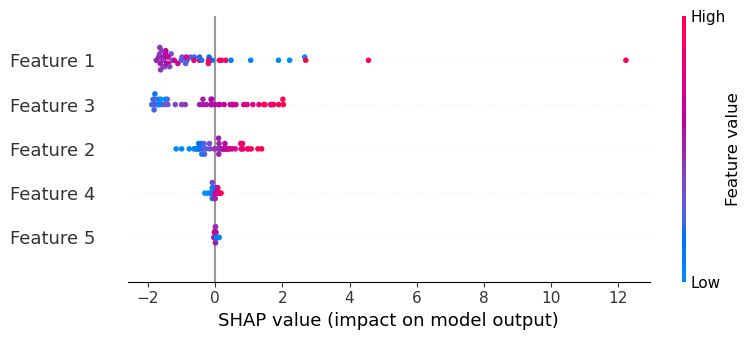

In [46]:
# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:test_sample_size], 
                  feature_names=feature_names)

<Figure size 1000x600 with 0 Axes>

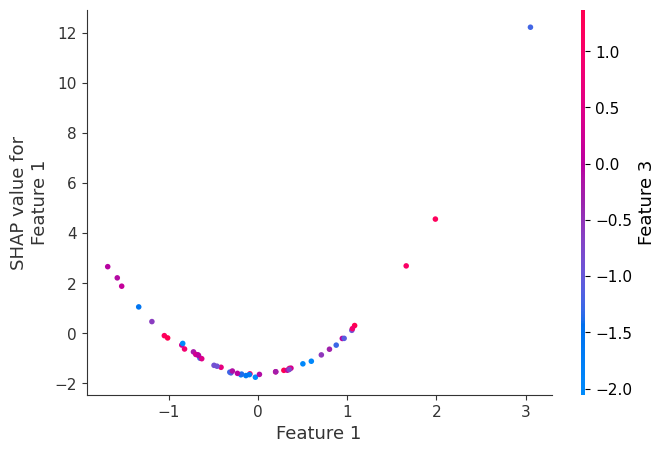

In [47]:
# SHAP Dependence Plot (most important feature)
plt.figure(figsize=(10, 6))
# Assuming feature 0 is important - you can change the index based on your results
shap.dependence_plot(0, shap_values, X_test_scaled[:test_sample_size], 
                     feature_names=feature_names)

In [48]:
# Create and save SHAP force plot for a single prediction
shap.initjs()  # Initialize JavaScript visualization

<Figure size 1000x600 with 0 Axes>

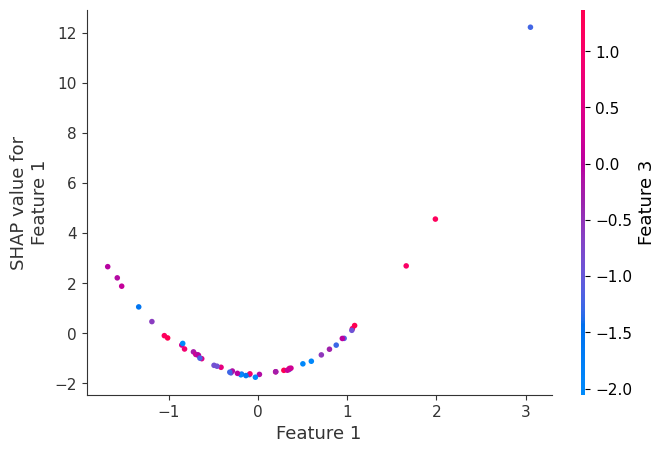

In [54]:
# SHAP Dependence Plot (most important feature)
plt.figure(figsize=(10, 6))
# Assuming feature 0 is important - you can change the index based on your results
shap.dependence_plot(0, shap_values, X_test_scaled[:test_sample_size], 
                     feature_names=feature_names)

In [55]:
# Handle different versions of SHAP
if isinstance(explainer.expected_value, np.ndarray):
    expected_value = explainer.expected_value[0]
else:
    expected_value = explainer.expected_value

In [56]:
# To display multiple samples in one force plot
shap.force_plot(expected_value, 
               shap_values[:5],  # First 5 samples
               X_test_scaled[:5], 
               feature_names=feature_names)

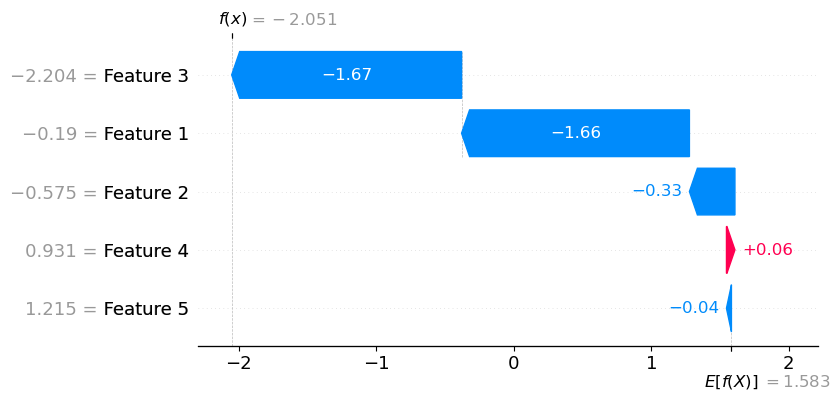

In [57]:
# For interactive waterfall plot (available in newer SHAP versions)
try:
    # Waterfall plot shows how we get from base value to the prediction
    shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                         base_values=expected_value, 
                                         data=X_test_scaled[0],
                                         feature_names=feature_names))
except:
    print("Waterfall plot not available in this SHAP version")